# Part 1 – Data Fetching

In [1]:
import sys
import subprocess
import pkg_resources

## Install missing packages

In [13]:
!pip install -q sseclient

## Define utility functions

In [6]:
from sseclient import SSEClient as EventSource
import time
import json

In [7]:
def hash_user(wiki, id):
    return hash((wiki, id))

In [8]:
def fetch_users(event_source, fetching_time_sec, message_types, wikis, event_decimation=5):
    observed_users = set()
    skipped_users = set()
    user_counter = 0
    print_log = False
    start_time = time.time()
    for event in event_source:
        try:
            change = json.loads(event.data)
        except:
            # ignore message
            continue

        if change["type"] not in message_types or change["wiki"] not in wikis:
            # ignore message
            continue

        user = hash_user(change["wiki"], change["user"])
        if user in observed_users:
            if print_log:
                print(f"Message from user {user} saved")
            save_user = True
        elif user in skipped_users:
            if print_log:
                print(f"Message from user {user} skipped")
            save_user = False
        else:
            # new user
            if user_counter % event_decimation == 0:
                if print_log:
                    print(f"+ Add new user {user}")
                observed_users.add(user)
                save_user = True
            else:
                if print_log:
                    print(f"- Add Skip user {user}")
                skipped_users.add(user)
                save_user = False
            user_counter += 1

        elapced_time = time.time() - start_time
        if elapced_time > fetching_time_sec:
            break

        if save_user:
            yield (change)

## Fetch events

In [9]:
url = 'https://stream.wikimedia.org/v2/stream/recentchange'
message_types = {"edit"}
wikis = {"enwiki", "wikidatawiki"}
wikis_str = "_".join(wikis)
fetching_time_sec = 200
changes = [change for change in fetch_users(EventSource(url), fetching_time_sec, message_types, wikis)]

print(f"Collected {len(changes)} edits")

with open(f"changes_{wikis_str}_{fetching_time_sec}_sec.json", "w", encoding="utf-8") as json_file:
    json.dump(changes, json_file, ensure_ascii=True, indent=4)

Collected 184 edits


## Description

There are several mesage types. We are interested only in type "edit".

Sample 20% of the stream - we record edits from every 5th new user in the stream. Other edits are skipped.

Wiki:
- enwiki
- wikidatawiki

# Part 2 – Model Definition

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Setup PySpark

In [11]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

In [12]:
!pip install -q findspark

In [16]:
!wget https://downloads.apache.org/spark/spark-3.5.0/spark-3.5.0-bin-hadoop3.tgz
!tar xzvf spark-3.5.0-bin-hadoop3.tgz

--2023-11-23 15:14:44--  https://downloads.apache.org/spark/spark-3.5.0/spark-3.5.0-bin-hadoop3.tgz
Resolving downloads.apache.org (downloads.apache.org)... 135.181.214.104, 88.99.95.219, 2a01:4f9:3a:2c57::2, ...
Connecting to downloads.apache.org (downloads.apache.org)|135.181.214.104|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 400395283 (382M) [application/x-gzip]
Saving to: ‘spark-3.5.0-bin-hadoop3.tgz’

spark-3.5.0-bin-had 100%[===================>] 381.85M  28.5MB/s    in 14s     

2023-11-23 15:14:58 (27.2 MB/s) - ‘spark-3.5.0-bin-hadoop3.tgz’ saved [400395283/400395283]



In [14]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.5.0-bin-hadoop3"

In [18]:
import findspark
findspark.init()

In [19]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import col, avg, when
import pandas as pd

In [20]:
sc = pyspark.SparkContext('local[*]')
spark = SparkSession(sc)
spark

## Upload data

In [28]:
%cd drive/MyDrive
%mkdir MMDB
%cd MMDB

/content/drive/MyDrive


In [31]:
!tar xzvf sample.tgz

tar (child): sample.tgz: Cannot open: No such file or directory
tar (child): Error is not recoverable: exiting now
tar: Child returned status 2
tar: Error is not recoverable: exiting now


In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import json

In [ ]:
# with open('sample_unique_users.jsonl', 'r') as fin:
#     samples = list(map(json.loads, fin.readlines()))

In [ ]:
with open('sample.jsonl', 'r') as fin:
    samples_1 = list(map(json.loads, fin.readlines()))

In [ ]:
# with open('sample_wikidata_15000sec.jsonl', 'r') as fin:
#     samples_2 = list(map(json.loads, fin.readlines()))

In [ ]:
df = spark.createDataFrame(samples_1)

In [ ]:
df.show(5)

In [ ]:
df.count()

## Describe the distribution of edits per users and bots

In [ ]:
df_bot_distr = df.select('user', 'bot').toPandas().drop_duplicates()

In [ ]:
df_bot_distr['bot'].value_counts()

In [ ]:
ax1 = plt.subplot(111)
df_distr = df.groupBy('user', 'bot').count().toPandas()
df_bots = df_distr[df_distr['bot']==True]
df_users = df_distr[df_distr['bot']==False]

df_users['count'].hist(ax=ax1, weights=100 * np.ones(len(df_users)) / len(df_users),
                       label='user', color='blue', alpha=0.5)
df_bots['count'].hist(ax=ax1, weights=100 * np.ones(len(df_bots)) / len(df_bots),
                      label='bot', color='red', alpha=0.5)

ax1.legend(loc='best')
# ax1.set_ylim((0, 100))
ax1.set_xlabel('N edits')
ax1.set_ylabel('% of users/bots')

In [ ]:
ax1 = plt.subplot(111)
df_distr = df.groupBy('user', 'bot').count().toPandas()
df_bots = df_distr[df_distr['bot']==True]
df_users = df_distr[df_distr['bot']==False]

df_users['count'].hist(ax=ax1,
                       label='user', color='blue', alpha=0.5)
df_bots['count'].hist(ax=ax1,
                      label='bot', color='red', alpha=0.5)

ax1.legend(loc='best')
ax1.set_ylim((0, 100))
ax1.set_xlabel('N edits')
ax1.set_ylabel('N of users/bots')

## Train bot detection model

### Difference length

In [ ]:
from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType

# the average length of all edits per user as a feature
@udf(IntegerType())
def diff_length(length):
  old = length['old']
  new = length['new']
  return abs(new - old)

In [ ]:
df = df.withColumn("length_difference", diff_length(df["length"]))

### Difference revision

In [ ]:
# # the average diff in revision of all edits per user as a feature
# @udf(IntegerType())
# def diff_revision(revision):
#   old = revision['old']
#   new = revision['new']
#   return abs(new - old)

In [ ]:
# df = df.withColumn("revision_difference", diff_length(df["revision"]))

In [ ]:
df = df.select('bot', 'user', "length_difference")

In [ ]:
from pyspark.sql.functions import count, mean, first

grouped_df = df.groupBy("user").agg(
    count("user").alias("count"),
    mean("length_difference").alias("mean_length_difference"),
    # mean("revision_difference").alias("mean_revision_difference"),
    first("bot").alias("bot")
)

In [ ]:
grouped_df.show(5)

In [ ]:
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import when

assembler = VectorAssembler(
  inputCols=["count", "mean_length_difference"], outputCol="features"
)

assembled = assembler.transform(grouped_df)

In [ ]:
assembled = assembled.withColumnRenamed("bot", "label").select('features', 'label', 'user')
assembled = assembled.withColumn('label', when(assembled.label, 1.0).otherwise(0.0))

In [ ]:
# for sample_unique_users.jsonl
# train_df, test_df = assembled.randomSplit(weights=[0.6,0.4], seed=10)
# valid_df, test_df = test_df.randomSplit(weights=[0.5, 0.5], seed=10)

In [ ]:
# for sample.jsonl
train_df, test_df = assembled.randomSplit(weights=[0.7,0.3], seed=100)
valid_df, test_df = test_df.randomSplit(weights=[0.5, 0.5], seed=100)

In [ ]:
train_df.groupBy('label').count().show()

In [ ]:
test_df.groupBy('label').count().show()

In [ ]:
valid_df.groupBy('label').count().show()

In [ ]:
train_df.count(), test_df.count(), valid_df.count()

### Undersampling + upsampling

Upsamping: copy 3 times bots \
Undersampling: took a sample of users which 10 times bigger than amount as upsampled bots

In [ ]:
df_pandas = train_df.toPandas()

In [ ]:
# for sample_unique_users.jsonl
# df_bots_pandas = df_pandas[df_pandas['label']==1.0]
# df_bots_pandas = pd.concat([df_bots_pandas, df_bots_pandas])

# df_users_pandas = df_pandas[df_pandas['label']==0.0].sample(n=20*len(df_bots_pandas))

# df_pandas_new_sample = pd.concat([df_users_pandas, df_bots_pandas])
# df_pandas_new_sample = df_pandas_new_sample.sample(frac = 1)

# df_pandas_new_sample['label'].value_counts()

In [ ]:
# for sample.jsonl
df_bots_pandas = df_pandas[df_pandas['label']==1.0]
df_bots_pandas = pd.concat([df_bots_pandas, df_bots_pandas, df_bots_pandas])

df_users_pandas = df_pandas[df_pandas['label']==0.0].sample(n=10*len(df_bots_pandas))

df_pandas_new_sample = pd.concat([df_users_pandas, df_bots_pandas])
df_pandas_new_sample = df_pandas_new_sample.sample(frac = 1)

df_pandas_new_sample['label'].value_counts()

In [ ]:
df_train_aug = spark.createDataFrame(df_pandas_new_sample)

In [ ]:
df_train_aug.show(5)

### Training

In [ ]:
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(labelCol="label", featuresCol="features", numTrees=10)

In [ ]:
model = rf.fit(df_train_aug)

### Test set predictions

In [ ]:
predictions = model.transform(test_df)

In [ ]:
df_pred = predictions.select('features', 'prediction', 'label').toPandas()

In [ ]:
df_pred['prediction'].value_counts()

In [ ]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics

evaluator = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction")
metrics = MulticlassMetrics(predictions.select("prediction", "label").rdd)

# print(metrics.confusionMatrix().toArray())
print("Precision bot-class: ", metrics.precision(1.0))
print("Precision user-class: ", metrics.precision(0.0))
print("Recall bot-class: ", metrics.recall(1.0))
print("Recall user-class: ", metrics.recall(0.0))
print("Weighted F1-score: ", metrics.weightedFMeasure())

### Validation set predictions

In [ ]:
predictions = model.transform(valid_df)

In [ ]:
df_pred_validation = predictions.select('user', 'prediction', 'label').toPandas()

In [ ]:
df_pred_validation['prediction'].value_counts()

In [ ]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics

evaluator = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction")
metrics = MulticlassMetrics(predictions.select("prediction", "label").rdd)

# print(metrics.confusionMatrix().toArray())
print("Precision bot-class: ", metrics.precision(1.0))
print("Precision user-class: ", metrics.precision(0.0))
print("Recall bot-class: ", metrics.recall(1.0))
print("Recall user-class: ", metrics.recall(0.0))
print("Weighted F1-score: ", metrics.weightedFMeasure())

In [ ]:
df_pred_validation

# Task 3 – Bloom Filter

1) Consider all the changes done in the wikipedia as stream.
** Check here: https://wikitech.wikimedia.org/wiki/RCStream

2) Each action is received in json format.

3) Data is full of bots. There is a flag were programmers can
indicate that an actions has been done by a bot.

4) Using this information as ground truth, develop a system able
to classify users as bot or human.

5) Constrain: You need to sample, and just use the 20% of
the data stream.

6) Describe the distribution of edits per users and bots.

7) Finally, train a Bloom Filter that filter out bots from the stream.

* Find the correct parameters for the bloom filter having an
error below 10%.

8) If you want to have a 100% you need to do this:

* Make your system to work with Spark Streaming (5%)

In [33]:
from sseclient import SSEClient as EventSource
import time
import json

In [34]:
# Define helper functions

def get_bin(x, bin_width, start=0):
    return (x - start) // bin_width

def hash_user(wiki, id):
    return hash((wiki, id))

def fetch_users(event_source, fetching_time_sec, message_types, wikis, event_decimation=5, print_log=False):
    observed_users = set()
    skipped_users = set()
    user_counter = 0
    start_time = time.time()
    for event in event_source:
        try:
            change = json.loads(event.data)
        except:
            # ignore message
            continue

        if change["type"] not in message_types or change["wiki"] not in wikis:
            # ignore message
            continue

        user = hash_user(change["wiki"], change["user"])
        if user in observed_users:
            if print_log:
                print(f"Message from user {user} saved")
            save_user = True
        elif user in skipped_users:
            if print_log:
                print(f"Message from user {user} skipped")
            save_user = False
        else:
            # new user
            if user_counter % event_decimation == 0:
                if print_log:
                    print(f"+ Add new user {user}")
                observed_users.add(user)
                save_user = True
            else:
                if print_log:
                    print(f"- Add Skip user {user}")
                skipped_users.add(user)
                save_user = False
            user_counter += 1

        elapced_time = time.time() - start_time
        if elapced_time > fetching_time_sec:
            break

        if save_user:
            yield (change)

In [35]:
url = 'https://stream.wikimedia.org/v2/stream/recentchange'
message_types = {"edit"}
wikis = {"enwiki"}#, "wikidatawiki"}
wikis_str = "_".join(wikis)

In [36]:
fetching_time_sec = 200

sample_items = [change for change in fetch_users(EventSource(url), fetching_time_sec, message_types, wikis)]

## Analyze bot behavior

In [46]:
import pandas as pd
import matplotlib.pyplot as plt

samples = []
with open('sample1.jsonl', 'r') as fin:
    samples.extend(list(map(json.loads, fin.readlines())))

df = pd.DataFrame(samples)


df['length_old'] = df.apply(lambda x: x['length']['old'], axis=1)
df['length_new'] = df.apply(lambda x: x['length']['new'], axis=1)
df['length_diff'] = df['length_new'] - df['length_old']
df['revision_diff'] = df.apply(lambda x: x['revision']['new'], axis=1) - df.apply(lambda x: x['revision']['old'], axis=1)

## split revision and length to buckets
df['length_bucket'] = df.length_diff.map(lambda x: get_bin(x, bin_width=50 ,start=df.length_diff.min()))
df['revision_bucket'] = df.revision_diff.map(lambda x: get_bin(x, bin_width=10 ,start=df.revision_diff.min()))

len(df)

8819

## Bot vs Real user edit length

In [47]:
df[df['bot']].sample()

,$schema,meta,id,type,namespace,title,title_url,comment,timestamp,user,...,server_name,server_script_path,wiki,parsedcomment,length_old,length_new,length_diff,revision_diff,length_bucket,revision_bucket
3492,/mediawiki/recentchange/1.0.0,{'uri': 'https://en.wikipedia.org/wiki/User:Am...,1697241759,edit,2,User:AmandaNP/SPI case list,https://en.wikipedia.org/wiki/User:AmandaNP/SP...,Updating SPI caselist,1700704895,DeltaQuadBot,...,en.wikipedia.org,/w,enwiki,Updating SPI caselist,36202,36202,0,1231,7244,123


In [48]:
df[~df['bot']].sample()

,$schema,meta,id,type,namespace,title,title_url,comment,timestamp,user,...,server_name,server_script_path,wiki,parsedcomment,length_old,length_new,length_diff,revision_diff,length_bucket,revision_bucket
7497,/mediawiki/recentchange/1.0.0,{'uri': 'https://en.wikipedia.org/wiki/Dennis_...,1697289394,edit,0,Dennis Barrie,https://en.wikipedia.org/wiki/Dennis_Barrie,fixed [[MOS:DASH|dashes]] using a [[User:GregU...,1700719029,Gilliam,...,en.wikipedia.org,/w,enwiki,"fixed <a href=""/wiki/MOS:DASH"" class=""mw-redir...",1738,1744,6,67944571,7244,6794457


(0.0, 0.0025)

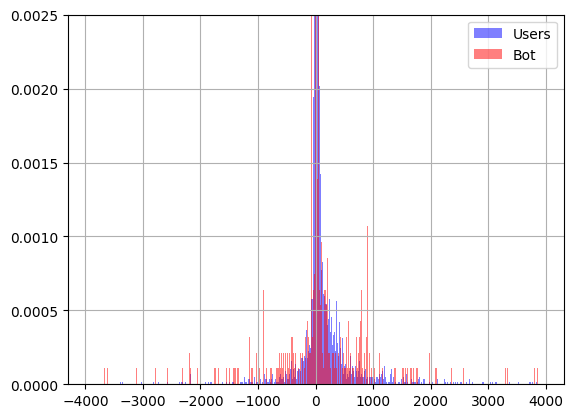

In [50]:
ax1 = plt.subplot(111)
df[~df['bot'] & (df['length_diff'].abs() < 4000)]['length_diff'].hist(ax=ax1, color='blue', label='Users', alpha=0.5, bins=1000, density=True)
df[df['bot'] & (df['length_diff'].abs() < 4000)]['length_diff'].hist(ax=ax1, color='red', label='Bot', alpha=0.5, bins=1000, density=True)
ax1.legend(loc='best')

ax1.set_ylim((0, 0.0025))

(0.0, 100.0)

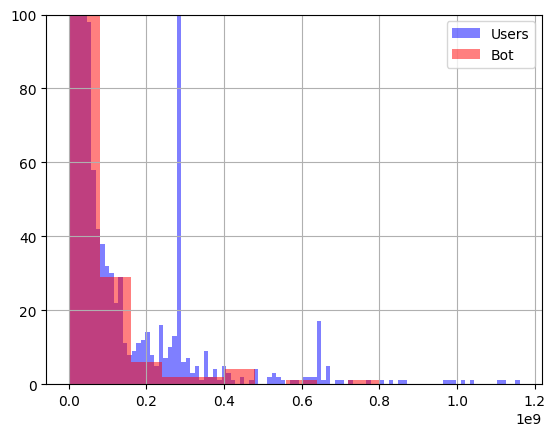

In [51]:
ax1 = plt.subplot(111)
df[~df['bot']]['revision_diff'].hist(ax=ax1, color='blue', label='Users', alpha=0.5, bins=100)
df[df['bot']]['revision_diff'].hist(ax=ax1, color='red', label='Bot', alpha=0.5)
ax1.legend(loc='best')

ax1.set_ylim((0, 100))

(0.0, 100000.0)

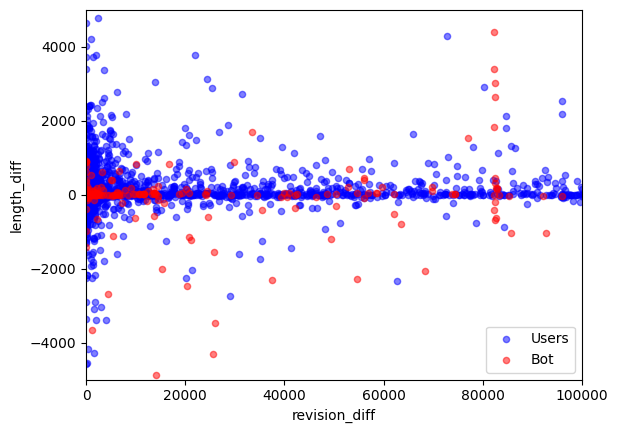

In [52]:
ax1 = plt.subplot(111)
df[~df['bot']].plot.scatter(x='revision_diff', y='length_diff', ax=ax1, color='blue', label='Users', alpha=0.5)
df[df['bot']].plot.scatter(x='revision_diff', y='length_diff', ax=ax1, color='red', label='Bot', alpha=0.5)
ax1.legend(loc='best')

ax1.set_ylim((-5000, 5000))
ax1.set_xlim((0, 100000))

Observations:
- real users makes bigger changes (>1k symbols per edit)
- changes between +/- 1k edited changes make both users and bots, so events are not distinguishable. Users do bigger and mostly additional edits (distribution right-skewed with longer tails comparing to bot distribution)
- bots has bot in the name (too obvious)
- bots generates comments in structured form
- revision diff is smaller for bots, it seems the reason is because bot need less time to make a change

## Bot behavior

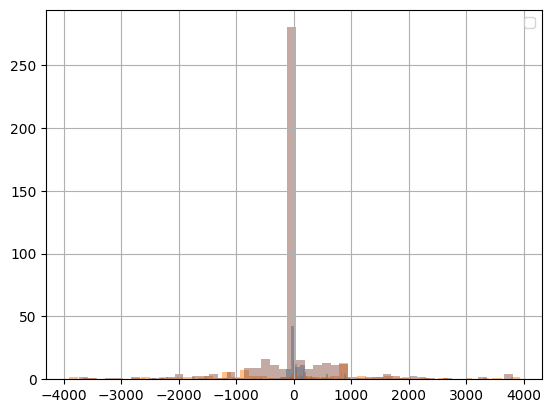

In [53]:
ax1 = plt.subplot(111)
df[df['bot'] & (df['length_diff'].abs() < 4000)].groupby('user')['length_diff'].hist(ax=ax1, alpha=0.5, bins=50)
ax1.legend(loc='best')

In [54]:
_df = df[df['bot']].groupby(['user'], as_index=False).agg(
                      {'length_diff':['count', 'mean','std']}).reset_index()
_df.dropna(inplace=True)

_df['mahalanobis'] = _df['length_diff']['mean'] / _df['length_diff']['std']
_df

index                    user length_diff                             \
                                       count         mean           std   
0      0               AnomieBOT          79     7.873418    375.700896   
2      2           AnomieBOT III           3  -253.333333    218.289563   
3      3                BattyBot          44    49.136364     23.698289   
4      4                 Bot1058           2    -7.500000     16.263456   
5      5                  Cewbot          11   310.454545    361.890139   
6      6             ChristieBot           6   220.333333    420.404408   
7      7            Citation bot         130    42.346154     98.789002   
8      8             ClueBot III          10 -1054.100000   2722.704515   
9      9         CommonsDelinker          15   -64.133333     46.913091   
11    11              Cyberbot I          28    45.000000    238.117618   
12    12                 DPL bot          20   459.050000    451.825592   
14    14            DYKUpdateBot           4   836.750000    636.861249   
15    15                  DatBot          16    44.062500     11.750000   
16    16            DeltaQuadBot          16   102.250000    145.816094   
20    20         Filedelinkerbot          13   -18.384615     84.156143   
21    21              FireflyBot           5   772.600000     10.139033   
22    22              GreenC bot          13   243.384615    164.937634   
23    23         ImageTaggingBot           6   771.000000    320.505226   
24    24      InternetArchiveBot          37   215.486486    157.845850   
25    25          JCW-CleanerBot           7    16.571429     21.938225   
26    26              JJMC89 bot           5   -83.600000    282.447871   
27    27          JJMC89 bot III          63   -53.380952     90.303329   
28    28                  JL-Bot           2  -168.500000    173.241161   
29    29                 Legobot          28    22.714286    143.080619   
30    30             ListeriaBot           2  1043.000000   1409.970922   
31    31  Lowercase sigmabot III         103   472.087379   6211.669958   
32    32              MajavahBot           2 -3449.000000   2887.824094   
33    33                 Mathbot           4   -81.000000    523.367939   
34    34              MilHistBot          11    47.727273     37.456884   
35    35                MusikBot           2 -1152.000000   1622.102956   
36    36             MusikBot II           5   -16.800000      0.447214   
38    38          Qwerfjkl (bot)           2    26.000000      0.000000   
39    39                RMCD bot           7    56.142857     71.277459   
40    40             Reports bot           5     7.000000     24.392622   
41    41               SDZeroBot          29  3092.103448  10378.066006   
42    42                 ST47Bot           2  -745.000000   1134.199277   
43    43                  Scsbot           2 -1831.000000   2590.839246   
44    44          SheepLinterBot           2     1.000000      0.000000   
45    45              WP 1.0 bot         489  -179.171779   3834.215820   
46    46                  WugBot           3   153.333333     84.701436   
47    47               Yapperbot          13   659.692308    369.771863   

   mahalanobis  
                
0     0.020957  
2    -1.160538  
3     2.073414  
4    -0.461157  
5     0.857870  
6     0.524099  
7     0.428653  
8    -0.387152  
9    -1.367067  
11    0.188982  
12    1.015989  
14    1.313865  
15    3.750000  
16    0.701226  
20   -0.218458  
21   76.200557  
22    1.475616  
23    2.405577  
24    1.365170  
25    0.755368  
26   -0.295984  
27   -0.591129  
28   -0.972633  
29    0.158752  
30    0.739732  
31    0.076000  
32   -1.194325  
33   -0.154767  
34    1.274192  
35   -0.710189  
36  -37.565942  
38         inf  
39    0.787666  
40    0.286972  
41    0.297946  
42   -0.656851  
43   -0.706721  
44         inf  
45   -0.046730  
46    1.810280  
47    1.784052

In [55]:
_df = df[~df['bot']].groupby(['user'], as_index=False).agg(
                      {'length_diff':['count', 'mean','std']}).reset_index()
_df.dropna(inplace=True)

_df['mahalanobis'] = _df['length_diff']['mean'] / _df['length_diff']['std']
_df

index                user length_diff                           \
                                     count        mean          std   
3        3          0xDeadbeef           3  130.666667   112.005952   
5        5         1.146.79.43           2  228.500000    85.559921   
15      15     103.152.119.190           2    0.000000     0.000000   
17      17        103.18.184.5           2   65.500000   191.625938   
18      18     103.182.130.227           3   42.333333    33.486316   
...    ...                 ...         ...         ...          ...   
2489  2489  মোহাম্মদ জনি হোসেন           2   47.500000     3.535534   
2490  2490           อย่ามาตบะ           6  -12.666667    41.960299   
2491  2491          ギルディアス156世           3  947.666667  1076.056380   
2492  2492                亚洲之星           7   12.857143    26.804406   
2493  2493               清风与明月           2   -2.000000    11.313708   

     mahalanobis  
                  
3       1.166605  
5       2.670643  
15           NaN  
17      0.341812  
18      1.264198  
...          ...  
2489   13.435029  
2490   -0.301873  
2491    0.880685  
2492    0.479665  
2493   -0.176777  

[1126 rows x 6 columns]

In [56]:
df[df['bot']]['user'].unique()

array(['DeltaQuadBot', 'AnomieBOT', 'RMCD bot', 'Filedelinkerbot',
       'Qwerfjkl (bot)', 'InternetArchiveBot', 'Cewbot', 'WP 1.0 bot',
       'DatBot', 'DYKUpdateBot', 'Bot1058', 'ChristieBot', 'AnomieBOT II',
       'Lowercase sigmabot III', 'DPL bot', 'FireflyBot', 'Mathbot',
       'SDZeroBot', 'DYKToolsBot', 'AnomieBOT III', 'Citation bot',
       'FACBot', 'MilHistBot', 'MusikBot', 'WugBot', 'Reports bot',
       'PearBOT', 'ClueBot III', 'DumbBOT', 'ST47Bot', 'Legobot',
       'SheepLinterBot', 'JJMC89 bot', 'JCW-CleanerBot', 'Scsbot',
       'MajavahBot', 'Yapperbot', 'MusikBot II', 'BattyBot',
       'CommonsDelinker', 'JJMC89 bot III', 'ImageTaggingBot',
       'Cyberbot I', 'JL-Bot', 'GreenC bot', 'EnterpriseyBot',
       'ListeriaBot', 'Community Tech bot'], dtype=object)

In [57]:
df[df['bot']]['comment'].sample(20).unique()

array(['Copying assessment table to wiki.', 'Update logs for past 7 days',
       'Alter: pages. Add: bibcode. | [[:en:WP:UCB|Use this bot]]. [[:en:WP:DBUG|Report bugs]]. | Suggested by Whoop whoop pull up | #UCB_webform 988/1083',
       'Add: publisher, authors 1-1. Removed parameters. Some additions/deletions were parameter name changes. | [[:en:WP:UCB|Use this bot]]. [[:en:WP:DBUG|Report bugs]]. | Suggested by Whoop whoop pull up | #UCB_webform 75/1977',
       '[[WP:FRS|Feedback Request Service]] notification on a "History and geography" request for comment (2/3 this month). You can unsubscribe at [[WP:FRS]].',
       '[[WP:FRS|Feedback Request Service]] notification on a "History and geography" request for comment (1/3 this month). You can unsubscribe at [[WP:FRS]].',
       'Updating report',
       'Moving [[:Category:Chinese scripts]] to [[:Category:Writing systems using Chinese characters]] per [[Wikipedia:Categories for discussion/Log/2023 November 3#Category:Chinese scripts

Observations:

- The bot title and comment seems to be significant features because uses special characters and more-less structured.
- Bots has different distributions: some do inserts and deletes that leads to two-modes bumps, some does small changes in page

## Collect data for model training

In [ ]:
# fetching_time_sec = 30000
# url = 'https://stream.wikimedia.org/v2/stream/recentchange'
# message_types = {"edit"}
# wikis = {"enwiki"}#, "wikidatawiki"}
# wikis_str = "_".join(wikis)

# with open('sample1.jsonl', 'w') as fout:
#     for item in fetch_users(EventSource(url), fetching_time_sec, message_types, wikis):
#         fout.write(json.dumps(item) + "\n")


## Read data

In [59]:
with open('sample1.jsonl', 'r') as fin:
    samples = list(map(json.loads, fin.readlines()))

df = pd.DataFrame(samples)

df['length_old'] = df.apply(lambda x: x['length']['old'], axis=1)
df['length_new'] = df.apply(lambda x: x['length']['new'], axis=1)
df['length_diff'] = df['length_new'] - df['length_old']
df['revision_diff'] = df.apply(lambda x: x['revision']['new'], axis=1) - df.apply(lambda x: x['revision']['old'], axis=1)

## split revision and length to buckets
df['length_bucket'] = df.length_diff.map(lambda x: get_bin(x, bin_width=50 ,start=df.length_diff.min()))
df['revision_bucket'] = df.revision_diff.map(lambda x: get_bin(x, bin_width=10 ,start=df.revision_diff.min()))

df.drop_duplicates(['user', 'title', 'comment'], inplace=True)

len(df)

7736

In [62]:
!pip install -q mmh3 bitarray

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.6/72.6 kB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 287.4/287.4 kB 7.3 MB/s eta 0:00:00


In [63]:
import math
import hashlib
import mmh3
from bitarray import bitarray


class BloomFilterBaseline(object):
    def __init__(self, filter_capacity, fp_error_rate):
        # number of stored items in bloom filter, spreaded between bits (mask)
        self._filter_capacity = filter_capacity
        self._fp_error_rate = fp_error_rate
        self._size = BloomFilter.calculate_size(self._filter_capacity, self._fp_error_rate)
        self._hash_functions = [
            lambda x: int.from_bytes(hashlib.sha256(x.encode('utf-8')).digest(), 'big'),
            # mmh3.hash
        ]
        self._mask_array = [0] * self._size

    @staticmethod
    def calculate_size(items_number, fp_error_rate):
        '''
        Size of bit array(m) to used using formula:
        m = -(n * lg(p)) / (lg(2)^2)
        '''
        return int(-(items_number * (math.log(fp_error_rate) / (math.log(2) ** 2))))

    def fit(self, X, Y):
        for x, y in zip(X, Y):
            if not y:
                continue
            for hash_func in self._hash_functions:
                index = hash_func(x) % self._size
                self._mask_array[index] = 1

    def predict_one(self, item):
        for hash_func in self._hash_functions:
            index = hash_func(item) % self._size
            if not self._mask_array[index]:
                return False
        return True

    def predict(self, items):
        return [self.predict_one(item) for item in items]



class BloomFilter(object):
    def __init__(self, filter_capacity, fp_error_rate):
        # number of stored items in bloom filter, spreaded between bits (mask)
        self._filter_capacity = filter_capacity
        self._fp_error_rate = fp_error_rate
        # number of buckets
        self._num_buckets = BloomFilter.calculate_num_buckets(self._filter_capacity, self._fp_error_rate)
        # number of hash functions to use for registering single record (functions differs by seed)
        self._num_hash_funcs = BloomFilter.calculate_num_of_hash_func(self._filter_capacity, self._num_buckets)

        self._buckets_array = [0] * self._num_buckets

    @staticmethod
    def calculate_num_buckets(items_number, fp_error_rate):
        '''
        Size of bit array(m) to used using formula:
        m = -(n * lg(p)) / (lg(2)^2)
        '''
        return int(-(items_number * (math.log(fp_error_rate) / (math.log(2) ** 2))))

    @staticmethod
    def calculate_num_of_hash_func(items_number, num_bits):
        return max(1, round(num_bits / items_number * math.log(2)))

    def _calc_hash(self, x, seed):
        return mmh3.hash(x, seed) % self._num_buckets

    def _add(self, x):
        for seed in range(self._num_hash_funcs):
            index = self._calc_hash(x, seed)
            self._buckets_array[index] = 1

    def fit(self, X, Y):
        for x, y in zip(X, Y):
            if not y:
                continue
            self._add(x)

    def predict_one(self, x):
        for seed in range(self._num_hash_funcs):
            index = self._calc_hash(x, seed)
            if not self._buckets_array[index]:
                return False
        return True

    def predict(self, items):
        return [self.predict_one(item) for item in items]


In [64]:
def extract_features(item):
    return item['user']

def extract_label(item):
    return item['bot']

In [65]:
import random
import numpy as np
from sklearn.metrics import classification_report, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

random.seed(42)

def get_train_test_random(_df, _extract_features=extract_features, _extract_label=extract_label):
    X = list(map(_extract_features, df.to_dict('records')))
    Y = list(map(_extract_label, df.to_dict('records')))
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
    return X_train, X_test, Y_train, Y_test

def get_train_test_users(_df, _extract_features=extract_features, _extract_label=extract_label):
    names = df.user.unique()
    names_train = random.choices(names, k=int(len(names)*0.8))
    df_train = df[df.user.isin(names_train)]
    df_test = df[~df.user.isin(names_train)]

    X_train = list(map(extract_features, df_train.to_dict('records')))
    Y_train = list(map(extract_label, df_train.to_dict('records')))

    X_test = list(map(extract_features, df_test.to_dict('records')))
    Y_test = list(map(extract_label, df_test.to_dict('records')))
    return X_train, X_test, Y_train, Y_test

In [66]:
X_train, X_test, Y_train, Y_test = get_train_test_random(df)

## Sanity check

In [67]:
model = BloomFilter(np.sum(Y_train), 0.01)
model.fit(X_train, Y_train)

In [68]:
y_pred = model.predict(X_test)

In [69]:
print(classification_report(Y_test, y_pred))

              precision    recall  f1-score   support

       False       1.00      0.99      0.99      1294
        True       0.96      0.99      0.97       254

    accuracy                           0.99      1548
   macro avg       0.98      0.99      0.98      1548
weighted avg       0.99      0.99      0.99      1548



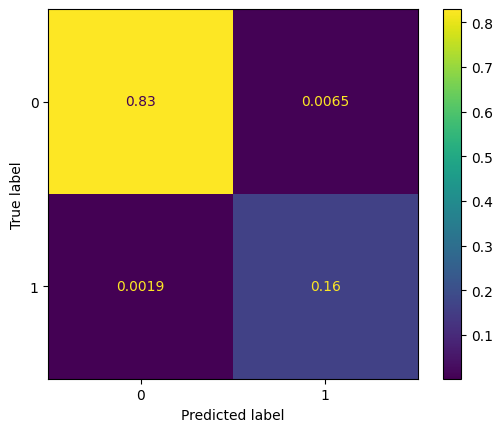

In [70]:
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(Y_test, y_pred) / len(Y_test))
disp.plot()

In [71]:
f1_score(Y_test, y_pred)

0.974757281553398

It looks classifier works as bot detection by names (it remembers user name of bots).

## Configuration search

### Features

- user name
- comment
- edit size
- revision diff
- edit + revision diff

### User name

In [72]:
def extract_features(item):
    return item['user']

X_train, X_test, Y_train, Y_test = get_train_test_users(df, _extract_features=extract_features)

model = BloomFilter(np.sum(Y_train), 0.01)
model.fit(X_train, Y_train)

y_pred = np.array(model.predict(X_test))

f1_score(Y_test, y_pred)

0.0

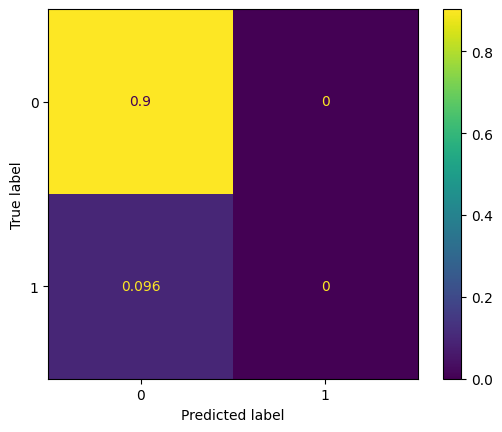

In [73]:
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(Y_test, y_pred) / len(Y_test))
disp.plot()

### Comment

In [74]:
def extract_features(item):
    return item['comment']

#### Split randomly

In [75]:
X_train, X_test, Y_train, Y_test = get_train_test_random(df, _extract_features=extract_features)

model = BloomFilter(np.sum(Y_train), 0.01)
model.fit(X_train, Y_train)

y_pred = model.predict(X_test)

f1_score(Y_test, y_pred)

0.7506053268765133

#### Split by user

In [76]:
X_train, X_test, Y_train, Y_test = get_train_test_users(df, _extract_features=extract_features)

model = BloomFilter(np.sum(Y_train), 0.01)
model.fit(X_train, Y_train)

y_pred = model.predict(X_test)

f1_score(Y_test, y_pred)

0.0027816411682892906

It seems bot users uses the same comments, but different bots uses different comments. This feature is not robust and needs additional investigation and preprocessing like BoW.

### Edit length

In [77]:
def extract_features(item):
    return str(item['length_diff'])

#### Split randomly

In [78]:
X_train, X_test, Y_train, Y_test = get_train_test_random(df, _extract_features=extract_features)

model = BloomFilter(np.sum(Y_train), 0.01)
model.fit(X_train, Y_train)

y_pred = model.predict(X_test)

f1_score(Y_test, y_pred)

0.26064291920069504

#### Split by user

In [79]:
X_train, X_test, Y_train, Y_test = get_train_test_users(df, _extract_features=extract_features)

model = BloomFilter(np.sum(Y_train), 0.01)
model.fit(X_train, Y_train)

y_pred = model.predict(X_test)

f1_score(Y_test, y_pred)

0.2825308396339037

### Edit length bucket

In [80]:
def extract_features(item):
    return str(item['length_bucket'])

#### Split randomly

In [81]:
X_train, X_test, Y_train, Y_test = get_train_test_random(df, _extract_features=extract_features)

model = BloomFilter(np.sum(Y_train), 0.01)
model.fit(X_train, Y_train)

y_pred = model.predict(X_test)

f1_score(Y_test, y_pred)

0.26918671248568155

#### Split by user

In [82]:
X_train, X_test, Y_train, Y_test = get_train_test_users(df, _extract_features=extract_features)

model = BloomFilter(np.sum(Y_train), 0.01)
model.fit(X_train, Y_train)

y_pred = model.predict(X_test)

f1_score(Y_test, y_pred)

0.35215487439502186

### Revision diff

In [83]:
def extract_features(item):
    return str(item['revision_diff'])

#### Split randomly

In [84]:
X_train, X_test, Y_train, Y_test = get_train_test_random(df, _extract_features=extract_features)

model = BloomFilter(np.sum(Y_train), 0.01)
model.fit(X_train, Y_train)

y_pred = model.predict(X_test)

f1_score(Y_test, y_pred)

0.2523076923076923

#### Split by user

In [85]:
X_train, X_test, Y_train, Y_test = get_train_test_users(df, _extract_features=extract_features)

model = BloomFilter(np.sum(Y_train), 0.01)
model.fit(X_train, Y_train)

y_pred = model.predict(X_test)

f1_score(Y_test, y_pred)

0.09459459459459459

### Revision diff bucket

In [86]:
def extract_features(item):
    return str(item['revision_bucket'])

#### Split randomly

In [87]:
X_train, X_test, Y_train, Y_test = get_train_test_random(df, _extract_features=extract_features)

model = BloomFilter(np.sum(Y_train), 0.01)
model.fit(X_train, Y_train)

y_pred = model.predict(X_test)

f1_score(Y_test, y_pred)

0.4513274336283186

#### Split by user

In [88]:
X_train, X_test, Y_train, Y_test = get_train_test_users(df, _extract_features=extract_features)

model = BloomFilter(np.sum(Y_train), 0.01)
model.fit(X_train, Y_train)

y_pred = model.predict(X_test)

f1_score(Y_test, y_pred)

0.13496932515337423

### Conclusions

- we observe significant gap between f1-scores depending on dataset split strategy: random split and per user split.
- Such a small scores for per user split strategy (considering Bloom filter specifics) were cased by small sample (only 3205 users contains in dataset, 51 users are bots). To increase scores we should increase test size
- there are few potential interesting features: comments and revision diff bucket that could be used for bot training.
- numbers bucketing improves performance of the model comparing to using actual numeric values. This idea matches with Bloom filter intuition but mask is generated depending on the value and is comparable (close values has higher chance to have the same hash sum)

## Parameters fine-tuning

There are few Bloom filter's parameters to finetune:
- filter capacity
- FP rate

Let's use comment as primary feature and find the best parameters to maximize f1 score for per-user split

In [89]:
def extract_features(item):
    return item['comment']

def extract_label(item):
    return item['bot']


X_train, X_test, Y_train, Y_test = get_train_test_users(df, _extract_features=extract_features, _extract_label=extract_label)

results = []

for item_count in [1, np.sum(Y_train)//50, np.sum(Y_train)//20, np.sum(Y_train)//10, np.sum(Y_train)/2, np.sum(Y_train)]:
    for fp_rate in [0.01, 0.05, 0.1, 0.2, 0.3]:

        model = BloomFilter(item_count, fp_rate)
        model.fit(X_train, Y_train)

        y_pred = model.predict(X_test)
        results.append({
            'fp_rate': fp_rate,
            'item_count': item_count,
            'f1_score': f1_score(Y_test, y_pred)
        })
pd.DataFrame(results).sort_values('f1_score', ascending=False)

,fp_rate,item_count,f1_score
18,0.20,79.0,0.295701
17,0.10,79.0,0.273803
10,0.01,39.0,0.271642
12,0.10,39.0,0.260994
8,0.20,15.0,0.215471
1,0.05,1.0,0.215471
14,0.30,39.0,0.215471
0,0.01,1.0,0.215471
7,0.10,15.0,0.215471
6,0.05,15.0,0.215471


The best score we can get for item numbers 53 and fp_rate = 5%

In [90]:
model = BloomFilter(101, 0.05)
model.fit(X_train, Y_train)

y_pred = model.predict(X_test)

print(classification_report(Y_test, y_pred))

              precision    recall  f1-score   support

       False       0.90      0.83      0.87      3073
        True       0.22      0.36      0.27       422

    accuracy                           0.77      3495
   macro avg       0.56      0.59      0.57      3495
weighted avg       0.82      0.77      0.79      3495

